In [1]:
import numpy as np
import pandas as pd
import pickle as pkl 
import xarray as xr
import copy
import os
import sys 
import metrics
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from scipy.spatial import distance
from numpy.linalg import LinAlgError
from IPython.display import clear_output
print("XArray version: ", xr.__version__)
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

XArray version:  0.16.1


In [2]:
##########################################################################################################
# LOAD IN THE DATA
##########################################################################################################
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb: 
    nwm_results = pkl.load(fb)

lstm_results_time_split1={}
mclstm_results_time_split1={}
sacsma_results_time_split1={}
lstm_results_time_split2={}
mclstm_results_time_split2={}
sacsma_results_time_split2={}

for forcing_type in ['nldas', 'daymet']:
    
    with open('./model_output_for_analysis/lstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split1[forcing_type] = pkl.load(fb)

    with open('./model_output_for_analysis/lstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split2[forcing_type] = pkl.load(fb)

train_split_type_model_set = {'time_split1':{'nwm':nwm_results, 
                                           'lstm':lstm_results_time_split1,
                                            'mc':mclstm_results_time_split1,
                                            'sac':sacsma_results_time_split1},
                              'time_split2':{'nwm':nwm_results,
                                           'lstm':lstm_results_time_split2,
                                            'mc':mclstm_results_time_split2,
                                            'sac':sacsma_results_time_split2}}

In [3]:
##########################################################################################################
# USE A CONVERSION BETWEEN MODELS AND DATA
##########################################################################################################
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [4]:
##########################################################################################################
# Get all the CAMELS attributes.  
##########################################################################################################

# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [5]:
##########################################################################################################
# Loop through all the SACSMA runs and check that the results are good. 
# Get a list of basins that has good calibration results.
##########################################################################################################
basin_list_all_camels = list(pd_attributes['basin_id_str'].values)
basin_list_sacsma_good = {ts:copy.deepcopy(basin_list_all_camels) for ts in ['time_split1', 'time_split2']}

for ib, basin_0str in enumerate(basin_list_all_camels): 
    remove_basin_id_from_list = False
    for train_split_type in ['time_split1', 'time_split2']:
        for forcing_type in ['nldas', 'daymet']:

            if basin_0str not in list(train_split_type_model_set[train_split_type]['sac'][forcing_type].columns):
                remove_basin_id_from_list = True
            elif train_split_type_model_set[train_split_type]['sac'][forcing_type][basin_0str].sum() <=0:
                remove_basin_id_from_list = True

            if train_split_type == 'time_split2' and forcing_type == 'nldas':
                if basin_0str not in list(train_split_type_model_set[train_split_type]['nwm'].keys()):
                    remove_basin_id_from_list = True

    if remove_basin_id_from_list:
        basin_list_sacsma_good[train_split_type].remove(basin_0str)

In [6]:
##########################################################################################################
#-------------------------------------------------------------------------------------------------
# Solve this problem. I think it is the xarray structures...
# isibleDeprecationWarning: Creating an ndarray from ragged nested sequences 
# (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
# If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
##########################################################################################################
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [7]:
##########################################################################################################
# REVERT TO THESE AS THE FLOWS
##########################################################################################################
flows = ['lstm', 'mc', 'sac', 'obs']


In [8]:
def get_specifications(tsplt, forcing_type):
    """
    This function is designed to return specific details of the simulation period
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    Returns
        start_date (pd.Timestamp): The date the simulation period started
        end_date (pd.Timestamp): The date the simulation period ended
        labelz (dictionary): A mapping between short model name and long model name
        models (list): the short model names
        flows (list): the short model names plus "obs" for observed flow
        basin_list (list): the list of basins that meet the criteria for analysis
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    """
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['nwm', 'lstm', 'mc', 'sac']
        flows = ['nwm', 'lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    elif tsplt == 'time_split2':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    else:
        start_date = pd.Timestamp('1989-10-01')
        end_date = pd.Timestamp('1999-09-30')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split1[forcing_type].keys())[:-1]

    spex = {"start_date":start_date,
            "end_date":end_date,
            "labelz":labelz,
            "models":models,
            "flows":flows, 
            "basin_list":basin_list,
            "tsplt":tsplt,
            "forcing_type":forcing_type}
    return spex #(start_date, end_date, labelz, models, flows, basin_list)

In [9]:
def get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date):
    #-------------------------------------------------------------------------------------------------
    # Make dictionary with all the flows
    flow_mm = {}
    #-------------------------------------------------------------------------------------------------
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS
        basin_area = pd_attributes.loc[int(basin_0str), 'area_geospa_fabric']\
        #-------------------------------------------------------------------------------------------------

        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values,
                 coords=[nwm_results[basin_0str]['streamflow'].index],
                 dims=['datetime'])
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        xrr = xr_nwm.loc[start_date:end_date]*3600*24/(basin_area*1000)
        flow_mm['nwm'] = pd.DataFrame(data=xrr.values)
    #-------------------------------------------------------------------------------------------------
    # Standard LSTM 
    if tsplt == 'time_split1':
        xrr = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # Mass-conserving LSTM data trained on all years
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # SACSMA Mean
    if tsplt == 'time_split1':
        df = sacsma_results_time_split1[forcing_type][basin_0str].loc[start_date:end_date]
    if tsplt == 'time_split2':
        df = sacsma_results_time_split2[forcing_type][basin_0str].loc[start_date:end_date]
    flow_mm['sac'] = df
    #-------------------------------------------------------------------------------------------------
    # OBSERVATIONS
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)

    #-------------------------------------------------------------------------------------------------
    # Make sure we are in a time period that all the flow members have values
    # If there is missin observations than we can't compare the mass of the observed with simulaitons
    skip_basin_because_missing_obs = False
    if tsplt == 'time_split1':
        obs_temp = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].datetime
    if tsplt == 'time_split2':
        obs_temp = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date
        
    return flow_mm, obs_temp


In [10]:
def scatter_plot_of_rr_events_for_basin(nldas, daymet, basin_0str, spex, plot_bounds=[0,2]):
    plt.scatter(nldas.RR_obs, nldas.RR_lstm, label="NLDAS lstm", c=colz[0])
    plt.scatter(nldas.RR_obs, nldas.RR_mc, label="NLDAS mc-lstm", c=colz[1])
    plt.scatter(nldas.RR_obs, nldas.RR_sac, label="NLDAS sac-sma", c=colz[2])
    plt.scatter(daymet.RR_obs, daymet.RR_lstm, marker="x", label="Daymet lstm", c=colz[0])
    plt.scatter(daymet.RR_obs, daymet.RR_mc, marker="x", label="Daymet mc-lstm", c=colz[1])
    plt.scatter(daymet.RR_obs, daymet.RR_sac, marker="x", label="Daymet sac-sma", c=colz[2])
    plt.title(f"runoff ratio at basin {basin_0str}")
    plt.xlabel("observed")
    plt.ylabel("simulated")
    plt.xlim(plot_bounds)
    plt.ylim(plot_bounds)
    plt.legend()
    plt.show()
    plt.close()

In [11]:
forcing_products = ['nldas','daymet']
file_name_map = {'nldas':'nldas', 'daymet':'cida'}
precip_column_map = {'nldas':'PRCP(mm/day)', 'daymet':'prcp(mm/day)'}

In [15]:
def precipitation_event_thresholds(percent_threshold, forcing):
    precip_threshold = 0
    # Event definition threshold
    any_precip = forcing[forcing>0].values
    any_precip.sort()
    onethrough = np.array([i for i in range(any_precip.shape[0])])/any_precip.shape[0]
    for i in range(any_precip.shape[0]):
        if onethrough[i] > percent_threshold:
            precip_threshold = any_precip[i]
            break
    return precip_threshold

def load_forcing_and_identify_events(tsplt, basin_0str, file_name_map, forcing_type):
    """
    This function loads in the forcing, and also identifies the indices of precipitation "events"
    Events are arbitrarily defined as any time the precipitation is greater than the median (non zero) precip
    
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        basin_0str (str): The basin ID as a string with a leading zero
        forcing_dir (str): The directory where to find the forcing file
        file_name_map (dictionary): 
        forcing_type (str): either nldas or daymet
        precip_threshold (float): The decimal number representing the event threshold percentage
    Return:
        forcing (pd.DataFrame): The forcing data for a particular basin
        precip_events (list): Indices of official precipitation "events"
    """
    
    forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
        f'/basin_mean_forcing/{forcing_type}_all_basins_in_one_directory/'
    
    basin_int = int(basin_0str)
    #-------------------------------------------------------------------------------------------------
    # FORCING
    forcing = pd.read_csv(f'{forcing_dir}{basin_0str}_lump_{file_name_map[forcing_type]}_forcing_leap.txt',
                          delim_whitespace=True, header=3)
    if tsplt == 'time_split1':
        forcing = forcing.iloc[3560:7214]
    if tsplt == 'time_split2':
        forcing = forcing.iloc[6118:]
    forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
    #-------------------------------------------------------------------------------------------------
    
    f_label = precip_column_map[forcing_type]
    
    
    precip_threshold_peak = precipitation_event_thresholds(0.25, forcing[f_label])
    precip_threshold_low = precipitation_event_thresholds(0.05, forcing[f_label])   
    
    # Identify events (criteria: precip days with two precip free days before and after)
    max_precip_event = 10
    event_window = 2
    precip_event_start_end_index = []
    for i in range(3, forcing[f_label].shape[0]-max_precip_event-event_window):
        if i < event_window or i > forcing[f_label].shape[0]-event_window:
            continue
        if forcing[f_label][i] > precip_threshold_peak:
            if np.sum(forcing[f_label][i-event_window:i]) < precip_threshold_low:
                for j in range(i+1,i+max_precip_event):
                    if forcing[f_label][j] == 0:
                        if np.sum(forcing[f_label][j:j+event_window]) < precip_threshold_low:
                            precip_event_start_end_index.append([i-event_window,j+event_window+1])
                        break
    print(f"Number of precipitation events {len(precip_event_start_end_index)} above threshold {precip_threshold_peak}mm and a window below {precip_threshold_low}mm")
    
    return forcing, precip_event_start_end_index

In [13]:
def calculate_mass_balance_over_events(basin_0str, spex, forcing, precip_events):
    
    basin_int = int(basin_0str)
    start_date = spex["start_date"]
    end_date = spex["end_date"]
    tsplt = spex["tsplt"]
    models = spex['models']
    flows = spex['flows']
    forcing_type = spex['forcing_type']
    
    mass_balance_over_events = pd.DataFrame(columns=["event",
                                                     "event_date",
                                                     "event_days",
                                                     "total_precip", 
                                                     "total_obs", 
                                                     "IN_obs",
                                                     "total_lstm",
                                                     "total_mc",
                                                     "total_sac",
                                                     "RR_obs",
                                                     "AME_lstm",
                                                     "PME_lstm",
                                                     "NME_lstm",
                                                     "RR_lstm",
                                                     "IN_lstm"
                                                     "AME_mc",
                                                     "PME_mc",
                                                     "NME_mc",
                                                     "RR_mc",
                                                     "IN_mc",
                                                     "AME_sac",
                                                     "PME_sac",
                                                     "NME_sac",
                                                     "RR_sac",
                                                     "IN_sac"])
    if "nwm" in models:
        mass_balance_over_events["total_nwm"] = np.nan
        mass_balance_over_events["AME_nwm"] = np.nan
        mass_balance_over_events["PME_nwm"] = np.nan
        mass_balance_over_events["NME_nwm"] = np.nan
        mass_balance_over_events["RR_nwm"] = np.nan
        mass_balance_over_events["IN_nwm"] = np.nan        
    
    #-------------------------------------------------------------------------------------------------    
    flow_mm, obs_temp = get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date)
    #-------------------------------------------------------------------------------------------------

                
        
    #-------------------------------------------------------------------------------------------------
    #################    DO MASS PER EVENT
    #-------------------------------------------------------------------------------------------------

    total_mass[forcing_type][tsplt][basin_0str] = {}
    
    
    #-------------------------------------------------------------------------------------------------
    # Define the event as the index of the maximum precipitation within the window.    
    for ievent, (sevd, eevd) in enumerate(precip_events):
        
        # The NWM ends before the other models. So stop time split 2 here.
        if tsplt == "time_split2" and eevd > 6301:
            continue
        
        max_precip=0
        for event_day in range(sevd, eevd+1):
            if forcing[precip_column_map[forcing_type]].values[event_day] > max_precip:
                max_precip = forcing[precip_column_map[forcing_type]].values[event_day]
                event = event_day
    
        #-------------------------------------------------------------------------------------------------
        # Set the total mass to zero for this basin    
        total_mass[forcing_type][tsplt][basin_0str][event] = {flow:0 for flow in flows}
        
        
        #-------------------------------------------------------------------------------------------------
        # Get the initial and total mass of each flow
        initial_event_flow = {flow:0 for flow in flows}
        for flow in flows:
            
            _flow = np.array(flow_mm[flow].iloc[sevd:eevd+1]).flatten()
            initial_event_flow[flow] = _flow[0]
            total_mass[forcing_type][tsplt][basin_0str][event][flow] = np.sum(_flow)
        if total_mass[forcing_type][tsplt][basin_0str][event]['obs'] == 0:
            continue
        else:
            mass_balance_over_events.loc[event,'event'] = event

        #-------------------------------------------------------------------------------------------------
        # Start filling in the event data
        ts = pd.to_datetime(str(forcing[precip_column_map[forcing_type]].index.values[event])) 
        d = ts.strftime('%Y.%m.%d')
        mass_balance_over_events.loc[event,'event_date'] = d
        mass_balance_over_events.loc[event,'event_days'] = eevd - sevd

        _precip = np.sum(forcing[precip_column_map[forcing_type]].values[sevd:eevd])
        mass_balance_over_events.loc[event,'total_precip'] = _precip
        
        mass_balance_over_events.loc[event,'total_obs'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['obs']

        mass_balance_over_events.loc[event,'RR_obs'] = \
            mass_balance_over_events.loc[event,'total_obs'] / \
            mass_balance_over_events.loc[event,'total_precip']

        for model in models:
            mass_balance_over_events.loc[event,f'total_{model}'] = \
                total_mass[forcing_type][tsplt][basin_0str][event][model]
        for flow in flows:
            mass_balance_over_events.loc[event,f'IN_{flow}'] = initial_event_flow[flow]
            
            
        #-------------------------------------------------------------------------------------------------
        # Calculate the model metrics
        for model in models:
            
            _obs = total_mass[forcing_type][tsplt][basin_0str][event]['obs']
            if _obs == 0:
                break
            _sim = total_mass[forcing_type][tsplt][basin_0str][event][model]
            
            mass_balance_over_events.loc[event,f'AME_{model}'] = np.abs(_sim - _obs) / _obs
            if (_sim - _obs) > 0:
                mass_balance_over_events.loc[event,f'PME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'NME_{model}'] = 0
            else:
                mass_balance_over_events.loc[event,f'NME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'PME_{model}'] = 0
                
            mass_balance_over_events.loc[event,f'RR_{model}'] = _sim / _precip

    return mass_balance_over_events



In [16]:
if False:
    with open("event_results.pkl", "rb") as fb:
        events_results = pkl.load(fb)
else:
    ##########################################################################################################
    # IDENTIFY EVENTS WITH PRECIP OVER 10mm
    # THEN DO THE MASS BALANCE CALC OVER SOME WINDOW
    ##########################################################################################################

    total_mass = {forcing_type:{time_split:{} for time_split in ['time_split1', 'time_split2']} for \
                           forcing_type in forcing_products}

    events_results = {tsplt: {forcing_type:{} for forcing_type in forcing_products} for \
                           tsplt in ['time_split1', 'time_split2']}

    for tsplt in ['time_split2', 'time_split1']:

        for forcing_type in forcing_products:

            forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
                '/basin_mean_forcing/{}_all_basins_in_one_directory/'.format(forcing_type)

            spex = get_specifications(tsplt, forcing_type)

            clear_every_5 = 0
            for basin_0str in spex["basin_list"]:

                print(basin_0str)

                forcing, precip_events = load_forcing_and_identify_events(tsplt, 
                                                                          basin_0str, 
                                                                          file_name_map, 
                                                                          forcing_type)
        
                events_results[tsplt][forcing_type][basin_0str] = calculate_mass_balance_over_events(basin_0str, 
                                                                              spex, 
                                                                              forcing, 
                                                                              precip_events)
            
                # I want to see what is going on, but I don't want to write too much to the screen
                if clear_every_5 >= 5:
                    clear_output(wait=True)
                    print(f'forcing_type: {forcing_type} for time split {tsplt}')
                    clear_every_5 = 0
                else:
                    clear_every_5 += 1
                    
#                 break
#             break
#         break
    with open("event_results.pkl", "wb") as fb:
        pkl.dump(events_results, fb)

forcing_type: daymet for time split time_split1
14325000
Number of precipitation events 104 above threshold 6.75mm and a window below 1.03mm
14362250
Number of precipitation events 138 above threshold 4.46mm and a window below 2.0mm


In [17]:
# Get rid of anything with NaNs
for tsplt in ['time_split2', 'time_split1']:
    for forcing_type in forcing_products:
        for basin_0str in spex["basin_list"]:
            df = events_results[tsplt][forcing_type][basin_0str]
            for i in df.index:
                if np.isnan(df['total_obs'][i]):
                    df = df.drop([i])
                elif tsplt == "time_split2" and forcing_type == "nldas":
                    if np.isnan(df['RR_nwm'][i]):
                        df = df.drop([i])

In [18]:
events_results['time_split2']['nldas'][basin_0str]

event  event_date event_days total_precip total_obs    IN_obs total_lstm  \
222    222  1997.05.11          6         2.66  1.848719   0.28351   2.034764   
255    255  1997.06.13         11         5.77  2.285796  0.206726   1.994999   
279    279  1997.07.07          9         1.88  1.216729  0.135848   1.493291   
304    304  1997.08.01          7         3.75  0.525674  0.070877   0.845938   
569    569  1998.04.23          9        13.83  5.244927  0.590645   4.377582   
...    ...         ...        ...          ...       ...       ...        ...   
6236  6236  2013.10.28          6         3.27  0.213223  0.033076     0.5864   
6258  6258  2013.11.19          7        23.82  0.401048  0.038392   0.745999   
6271  6271  2013.12.02          7         13.5  0.396913  0.046661   0.627625   
6276  6276  2013.12.07          7         6.49  0.395732  0.048433   0.502108   
6290  6290  2013.12.21          6         2.48  0.419358  0.059065   0.518758   

      total_mc total_sac    RR_obs  ...    RR_sac    IN_sac  total_nwm  \
222   2.077515  1.753408  0.695007  ...  0.659176    0.2583   3.010939   
255    0.84154  2.053473  0.396152  ...  0.355888  0.187717   1.940292   
279   0.560252  1.195215  0.647196  ...  0.635753   0.12571   0.721149   
304   0.129275  0.715449   0.14018  ...  0.190786  0.091543   0.230538   
569   6.020142  4.121371  0.379243  ...  0.298002  0.455399  13.248131   
...        ...       ...       ...  ...       ...       ...        ...   
6236  0.166235  0.182333  0.065206  ...  0.055759  0.024638   0.000000   
6258  0.344775   0.26387  0.016837  ...  0.011078  0.020788   0.000000   
6271  0.283969  0.172555  0.029401  ...  0.012782  0.015696   0.000000   
6276  0.343521  0.123045  0.060976  ...  0.018959  0.019236   0.000000   
6290  0.274693  0.095189  0.169096  ...  0.038383   0.01229   0.000000   

       AME_nwm   PME_nwm   NME_nwm    RR_nwm    IN_nwm   IN_lstm    AME_mc  
222   0.628662  0.628662  0.000000  1.131932  0.500456  0.309590  0.123759  
255   0.151153  0.000000 -0.151153  0.336272  0.177211  0.183558  0.631840  
279   0.407305  0.000000 -0.407305  0.383590  0.078760  0.171279  0.539543  
304   0.561443  0.000000 -0.561443  0.061477  0.039380  0.124013  0.754079  
569   1.525894  1.525894  0.000000  0.957927  1.562899  0.482922  0.147803  
...        ...       ...       ...       ...       ...       ...       ...  
6236  1.000000  0.000000 -1.000000  0.000000  0.000000  0.094705  0.220369  
6258  1.000000  0.000000 -1.000000  0.000000  0.000000  0.071107  0.140314  
6271  1.000000  0.000000 -1.000000  0.000000  0.000000  0.090349  0.284556  
6276  1.000000  0.000000 -1.000000  0.000000  0.000000  0.071148  0.131935  
6290  1.000000  0.000000 -1.000000  0.000000  0.000000  0.089538  0.344968  

[136 rows x 32 columns]

In [19]:
def mahalanobis_distances(df, axis=0):
    '''
    Returns a pandas Series with Mahalanobis distances for each sample on the
    axis.

    Note: does not work well when # of observations < # of dimensions
    Will either return NaN in answer
    or (in the extreme case) fail with a Singular Matrix LinAlgError

    Args:
        df: pandas DataFrame with columns to run diagnostics on
        axis: 0 to find outlier rows, 1 to find outlier columns
    '''
    df = df.transpose() if axis == 1 else df
    means = df.mean()
    try:
        inv_cov = np.linalg.inv(df.cov())
    except LinAlgError:
        return pd.Series([np.NAN] * len(df.index), df.index,
                         name='Mahalanobis')
    dists = []
    for i, sample in df.iterrows():
        dists.append(distance.mahalanobis(sample, means, inv_cov))

    return pd.Series(dists, df.index, name='Mahalanobis') 

In [21]:
# Calculate the location of each runoff event within the "local" distribution
for tsplt in ['time_split1', 'time_split2']:
    for forcing_type in forcing_products:
        spex = get_specifications(tsplt, forcing_type)
        for basin_0str in spex["basin_list"]:
            for flow in spex['flows']:
                u = events_results[tsplt][forcing_type][basin_0str][f'IN_{flow}']
                v = events_results[tsplt][forcing_type][basin_0str][f'total_precip']
                df = pd.DataFrame(data=[u,v], columns=u.index.values).transpose()
                events_results[tsplt][forcing_type][basin_0str][f'MD_{flow}'] = mahalanobis_distances(df)
                
#                 print(md.sort_values())
                
#                 break
#             break
#         break
#     break

In [22]:
events_results[tsplt][forcing_type][basin_0str]

event  event_date event_days total_precip  total_obs    IN_obs  \
17      17  1996.10.18          7        37.81   0.500867  0.040755   
23      23  1996.10.24         10         74.4   1.033629  0.064971   
28      28  1996.10.29          6         15.5   0.667429  0.070877   
116    116  1997.01.25          9        45.64  18.428125  1.240355   
122    122  1997.01.31          7         14.1  12.580739  2.126322   
...    ...         ...        ...          ...        ...       ...   
6199  6199  2013.09.21          6        19.24   0.147661       0.0   
6208  6208  2013.09.30          7        51.02   0.545165  0.044889   
6247  6247  2013.11.08          6         4.94   0.237439  0.033076   
6259  6259  2013.11.20          8        25.72   0.445346  0.038392   
6276  6276  2013.12.07          6         12.5   0.347299  0.047842   

     total_lstm  total_mc total_sac    RR_obs  ... PME_sac NME_sac RR_sac  \
17     0.398846   0.14572       0.0  0.013247  ...       0    -1.0    0.0   
23     0.901154  0.683183       0.0  0.013893  ...       0    -1.0    0.0   
28      0.66035  0.654743       0.0   0.04306  ...       0    -1.0    0.0   
116   21.056543  14.26174       0.0  0.403771  ...       0    -1.0    0.0   
122   15.117903  7.651967       0.0  0.892251  ...       0    -1.0    0.0   
...         ...       ...       ...       ...  ...     ...     ...    ...   
6199   0.096042  0.097422       0.0  0.007675  ...       0    -1.0    0.0   
6208   0.259249  0.725197       0.0  0.010685  ...       0    -1.0    0.0   
6247   0.299441  0.319464       0.0  0.048065  ...       0    -1.0    0.0   
6259    0.42487  0.239806       0.0  0.017315  ...       0    -1.0    0.0   
6276   0.396671  0.389679       0.0  0.027784  ...       0    -1.0    0.0   

     IN_sac   IN_lstm    AME_mc   MD_lstm     MD_mc MD_sac    MD_obs  
17      0.0  0.045203  0.709065  0.551749  0.777066    NaN  0.593098  
23      0.0  0.069469  0.339044  1.369335  1.443446    NaN  1.382637  
28      0.0  0.095697  0.019007  0.586217  0.675360    NaN  0.658880  
116     0.0  1.713330  0.226088  4.138812  2.919105    NaN  2.697100  
122     0.0  2.123666  0.391771  5.298494  3.854563    NaN  5.078154  
...     ...       ...       ...       ...       ...    ...       ...  
6199    0.0  0.009468  0.340232  0.697321  0.833569    NaN  0.748778  
6208    0.0  0.021625  0.330233  0.834342  0.931823    NaN  0.809623  
6247    0.0  0.036462  0.345456  0.933360  1.057845    NaN  0.961176  
6259    0.0  0.041676  0.461530  0.540608  0.736447    NaN  0.582465  
6276    0.0  0.056580  0.122025  0.722846  0.873027    NaN  0.765029  

[217 rows x 30 columns]

In [23]:
# Q - Q plot.

In [32]:
def get_cum_dist_x_y(series):
    x = list(series)
    y = list(range(len(x)))
    for i, _ in enumerate(y):
        y[i] = y[i]/len(y)
    x.sort()
    return x, y

In [34]:
def calculate_rr_location_within_nn_distribution(rr, rr_dist):
    """
        Args:
            rr (float): A runoff ratio for a particular event. 
            rr_dist (series): a sorted series of runoff ratios

    """

    x,y = get_cum_dist_x_y(rr)

    percentile = None
    
    for i, j in zip(x,y):
        if i > rr:
            percentile = y

    return percentile

In [26]:
from sklearn.metrics import r2_score
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [28]:
print("Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)")



for tsplt in ['time_split1', 'time_split2']:
    
    spex = get_specifications(tsplt, 'nldas')
        
    rr_nldas_obs = []
    rr_nldas_lstm = []
    rr_nldas_mc = []
    rr_nldas_sac = []
    rr_daymet_obs = []
    rr_daymet_lstm = []
    rr_daymet_mc = []
    rr_daymet_sac = []
    
    if tsplt == 'time_split2':
        rr_nldas_nwm = []
    
    for i, basin_0str in enumerate(spex["basin_list"]):
        
        _nldas = events_results[tsplt]['nldas'][basin_0str]
        nn_nldas = np.min([100, _nldas.shape[0]])
        _daymet = events_results[tsplt]['daymet'][basin_0str]
        nn_daymet = np.min([100, _daymet.shape[0]])
        
        if tsplt == 'time_split2':
            if np.isnan(list(_nldas.RR_nwm.values)).sum() == 0:
                if np.isnan(list(_nldas.RR_obs.values)).sum() == 0:
                    rr_nldas_nwm.extend(list(_nldas.sort_values('MD_obs')['RR_nwm'][:nn_nldas]))                
                    rr_nldas_obs.extend(list(_nldas.sort_values('MD_obs')['RR_obs'][:nn_nldas]))
                    rr_nldas_lstm.extend(list(_nldas.sort_values('MD_obs')['RR_lstm'][:nn_nldas])) 
                    rr_nldas_mc.extend(list(_nldas.sort_values('MD_obs')['RR_mc'][:nn_nldas])) 
                    rr_nldas_sac.extend(list(_nldas.sort_values('MD_obs')['RR_sac'][:nn_nldas])) 
        elif np.isnan(list(_nldas.RR_obs.values)).sum() == 0:
            rr_nldas_obs.extend(list(_nldas.sort_values('MD_obs')['RR_obs'][:nn_nldas]))
            rr_nldas_lstm.extend(list(_nldas.sort_values('MD_obs')['RR_lstm'][:nn_nldas])) 
            rr_nldas_mc.extend(list(_nldas.sort_values('MD_obs')['RR_mc'][:nn_nldas])) 
            rr_nldas_sac.extend(list(_nldas.sort_values('MD_obs')['RR_sac'][:nn_nldas]))
        
        if np.isnan(list(_daymet.RR_obs.values)).sum() ==0:
            rr_daymet_obs.extend(list(_daymet.sort_values('MD_obs')['RR_obs'][:nn_daymet]))
            rr_daymet_lstm.extend(list(_daymet.sort_values('MD_obs')['RR_lstm'][:nn_daymet])) 
            rr_daymet_mc.extend(list(_daymet.sort_values('MD_obs')['RR_mc'][:nn_daymet])) 
            rr_daymet_sac.extend(list(_daymet.sort_values('MD_obs')['RR_sac'][:nn_daymet]))
        
    df = pd.DataFrame(columns=["forcing", "model", "MI", "R2", "n"])
    df.loc[len(df)] = ["NLDAS", "LSTM", 
             np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_lstm, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    df.loc[len(df)] = ["NLDAS", "MC-LSTM", 
             np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_mc, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    df.loc[len(df)] = ["NLDAS", "SAC-SMA", 
             np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_sac, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    if tsplt == 'time_split2':
        df.loc[len(df)] = ["NLDAS", "NWM", 
             np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_nwm, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    df.loc[len(df)] = ["Daymet", "LSTM", 
             np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3),
             np.round(r2_score(rr_daymet_lstm, rr_daymet_obs),3),
             len(rr_daymet_obs)]
    df.loc[len(df)] = ["Daymet", "MC-LSTM", 
             np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3),
             np.round(r2_score(rr_daymet_mc, rr_daymet_obs),3),
             len(rr_daymet_obs)]
    df.loc[len(df)] = ["Daymet", "SAC-SMA", 
             np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3),
             np.round(r2_score(rr_daymet_sac, rr_daymet_obs),3),
             len(rr_daymet_obs)]
    print(f"For {tsplt}")
    print("Mutual information between observed and predicted Runoff Ratios")
    print(f"{len(rr_nldas_obs)} total events with NLDAS")
    print("NLDAS LSTM", np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3))
    print("NLDAS MC-LSTM", np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3))
    print("NLDAS Sac-SMA", np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3))
    if tsplt == 'time_split2':
        print("NLDAS NWM", np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3))
    print(f"{len(rr_daymet_obs)} total events with Daymet")
    print("Daymet LSTM", np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3))
    print("Daymet MC-LSTM", np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3))
    print("Daymet Sac-SMA", np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3))
    print(" ")
    print(df)

Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)
For time_split1
Mutual information between observed and predicted Runoff Ratios
42858 total events with NLDAS
NLDAS LSTM 0.165
NLDAS MC-LSTM 0.15
NLDAS Sac-SMA 0.12
52359 total events with Daymet
Daymet LSTM 0.602
Daymet MC-LSTM 0.523
Daymet Sac-SMA 0.439
 
  forcing    model     MI     R2      n
0   NLDAS     LSTM  0.165  0.903  42858
1   NLDAS  MC-LSTM  0.150  0.849  42858
2   NLDAS  SAC-SMA  0.120  0.831  42858
3  Daymet     LSTM  0.602  0.897  52359
4  Daymet  MC-LSTM  0.523  0.866  52359
5  Daymet  SAC-SMA  0.439  0.752  52359
For time_split2
Mutual information between observed and predicted Runoff Ratios
46318 total events with NLDAS
NLDAS LSTM 0.217
NLDAS MC-LSTM 0.206
NLDAS Sac-SMA 0.132
NLDAS NWM 0.198
48421 total events with Daymet
Daymet LSTM 0.677
Daymet MC-LSTM 0.647
Daymet Sac-SMA 0.479
 
  forcing    model     MI     R2      n
0   NLDAS     LSTM  0.217  0.897  46318
1   NLDAS  

In [29]:
def plot_runoff_ratio_distribution(tsplt, basin_0str, _nldas, _daymet):
    x,y = get_cum_dist_x_y(_nldas['RR_obs'].values)
    plt.plot(x,y, label="NLDAS Observed", c='k')
    x,y = get_cum_dist_x_y(_nldas['RR_lstm'].values)
    max_obs_nldas = np.max(x)
    plt.plot(x,y, label="NLDAS lstm", c=colz[0])
    x,y = get_cum_dist_x_y(_nldas['RR_mc'].values)
    plt.plot(x,y, label="NLDAS mc-lstm", c=colz[1])
    x,y = get_cum_dist_x_y(_nldas['RR_sac'].values)
    plt.plot(x,y, label="NLDAS sac-sma", c=colz[2])
    if tsplt == "time_split2":
        x,y = get_cum_dist_x_y(_nldas['RR_nwm'].values)
        plt.plot(x,y, label="NLDAS NWM", c=colz[3])

    x,y = get_cum_dist_x_y(_daymet['RR_obs'].values)
    plt.plot(x,y,'--',label="Daymet Observed", c='k')
    max_obs_daymet = np.max(x)
    x,y = get_cum_dist_x_y(_daymet['RR_lstm'].values)
    plt.plot(x,y,'--',label="Daymet lstm", c=colz[0])
    x,y = get_cum_dist_x_y(_daymet['RR_mc'].values)
    plt.plot(x,y,'--',label="Daymet mc-lstm", c=colz[1])
    x,y = get_cum_dist_x_y(_daymet['RR_sac'].values)
    plt.plot(x,y,'--',label="Daymet sac-sma", c=colz[2])

    plt.title(basin_0str)
    plt.ylabel("non-exceedance probability, P(x ≤ x*)")
    plt.xlabel("Runoff Ratio")
    max_observed = np.max(np.array([max_obs_nldas, max_obs_daymet]))
    plt.xlim([0,max_observed])
    plt.show()
    plt.close()

LSTM absolute mass error 0.48 0.41
MC-LSTM absolute mass error 0.58 0.7
SacSMA absolute mass error 0.43 0.62


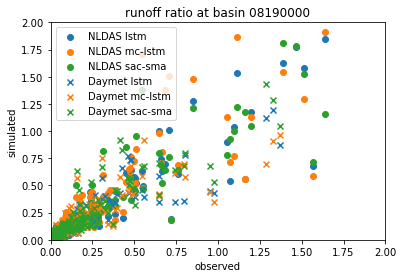

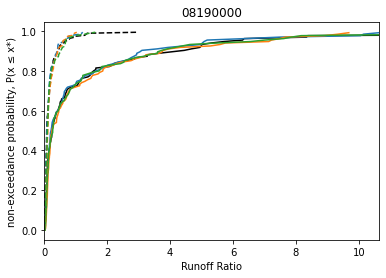

LSTM absolute mass error 0.6 0.7
MC-LSTM absolute mass error 0.8 0.78
SacSMA absolute mass error 0.57 0.56


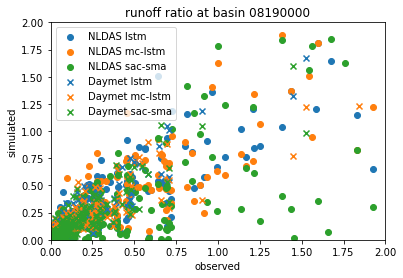

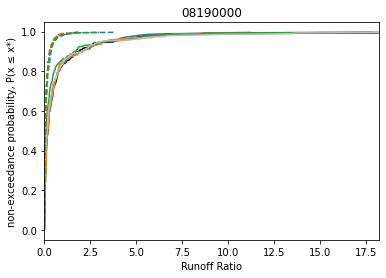

LSTM absolute mass error 4.57 5.46
MC-LSTM absolute mass error 11.04 14.61
SacSMA absolute mass error 20.88 9.82


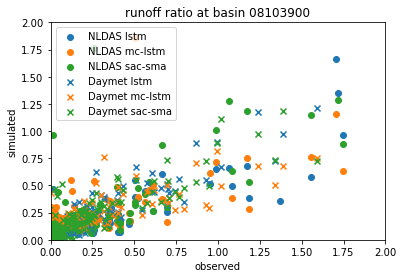

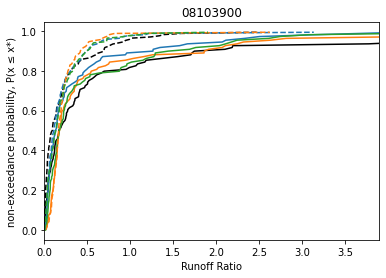

LSTM absolute mass error 23.65 9.35
MC-LSTM absolute mass error 26.61 18.8
SacSMA absolute mass error 8.14 8.54


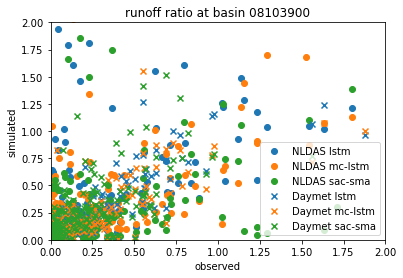

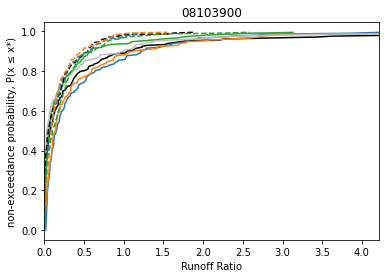

LSTM absolute mass error 0.28 0.32
MC-LSTM absolute mass error 0.39 0.31
SacSMA absolute mass error 0.44 0.5


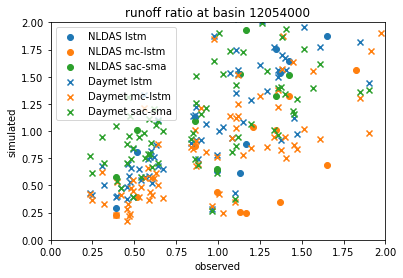

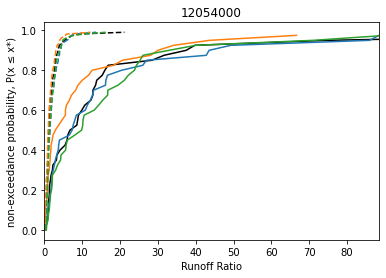

LSTM absolute mass error 0.23 0.29
MC-LSTM absolute mass error 0.31 0.3
SacSMA absolute mass error 0.34 0.33


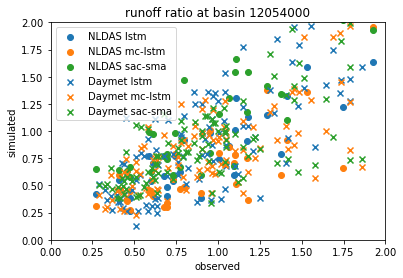

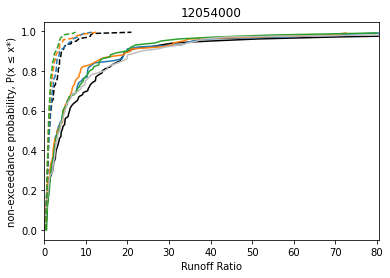

LSTM absolute mass error 0.14 0.1
MC-LSTM absolute mass error 0.15 0.21
SacSMA absolute mass error 0.2 0.17


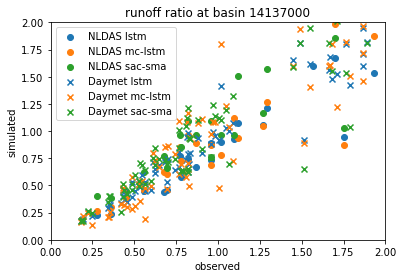

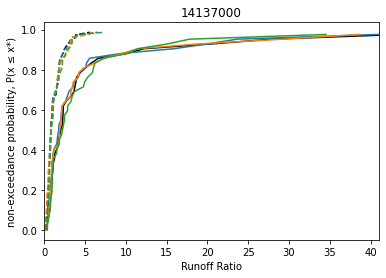

LSTM absolute mass error 0.17 0.13
MC-LSTM absolute mass error 0.19 0.18
SacSMA absolute mass error 0.26 0.26


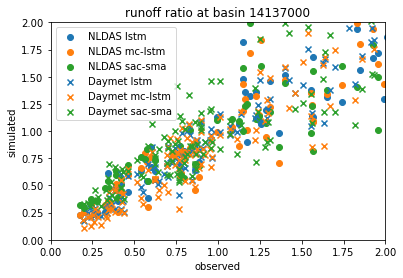

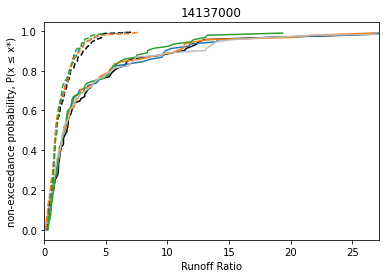

LSTM absolute mass error 0.25 0.21
MC-LSTM absolute mass error 0.32 0.2
SacSMA absolute mass error 0.17 0.22


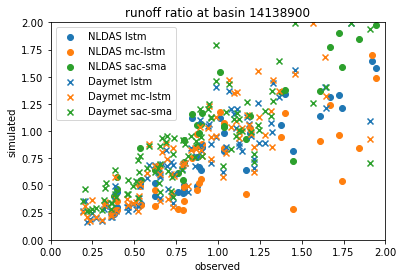

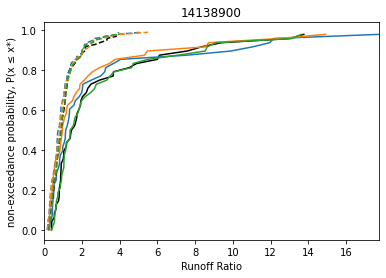

LSTM absolute mass error 0.23 0.2
MC-LSTM absolute mass error 0.3 0.2
SacSMA absolute mass error 0.29 0.28


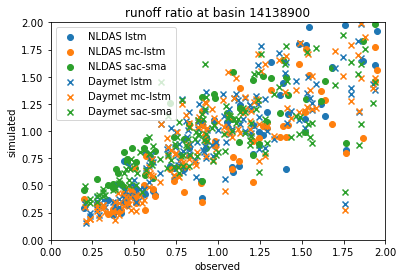

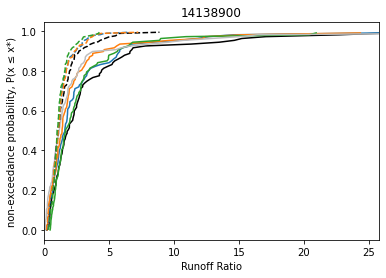

LSTM absolute mass error 0.27 0.25
MC-LSTM absolute mass error 0.32 0.27
SacSMA absolute mass error 0.84 0.51


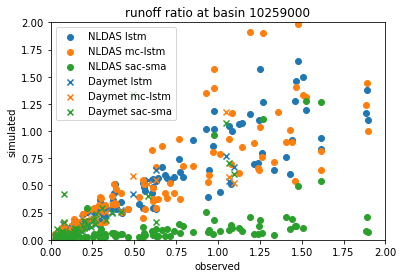

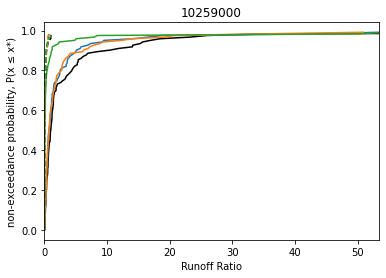

LSTM absolute mass error 0.87 0.45
MC-LSTM absolute mass error 0.91 0.55
SacSMA absolute mass error 0.6 0.56


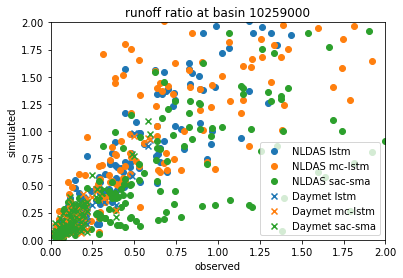

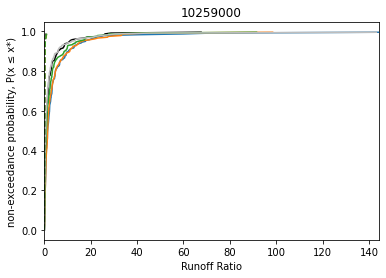

LSTM absolute mass error 0.18 0.14
MC-LSTM absolute mass error 0.32 0.22
SacSMA absolute mass error 0.42 0.53


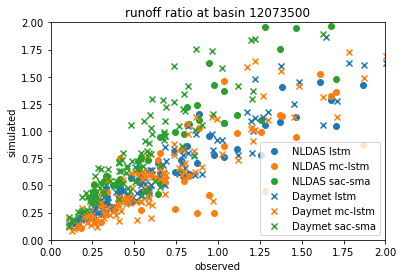

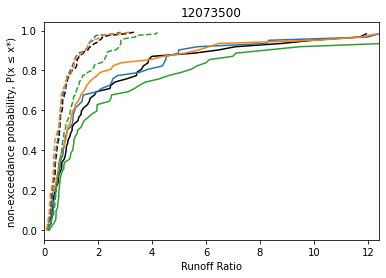

LSTM absolute mass error 0.2 0.14
MC-LSTM absolute mass error 0.31 0.22
SacSMA absolute mass error 0.33 0.36


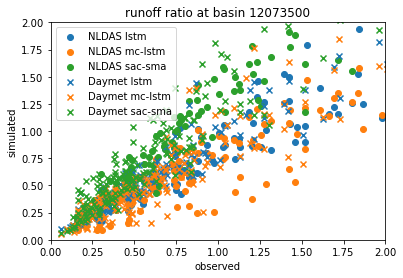

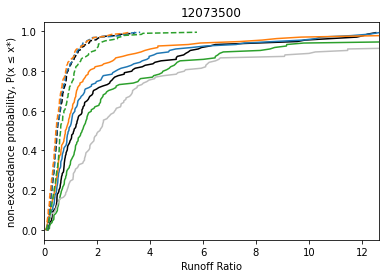

LSTM absolute mass error 0.29 0.35
MC-LSTM absolute mass error 0.24 0.36
SacSMA absolute mass error 0.54 0.74


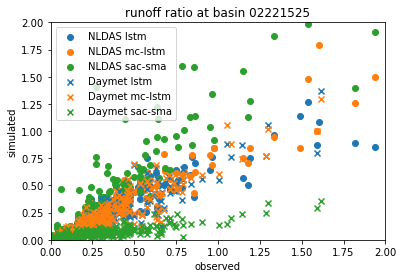

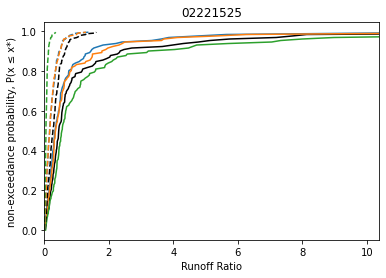

LSTM absolute mass error 0.88 0.75
MC-LSTM absolute mass error 0.94 0.74
SacSMA absolute mass error 1.89 3.26


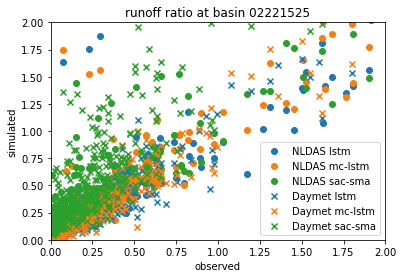

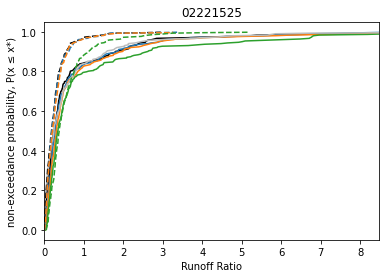

LSTM absolute mass error 0.14 0.13
MC-LSTM absolute mass error 0.24 0.22
SacSMA absolute mass error 0.28 0.25


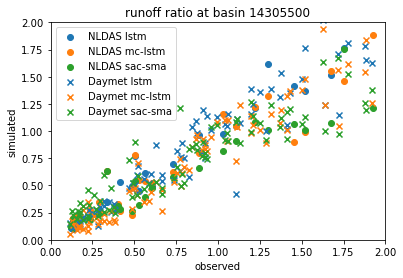

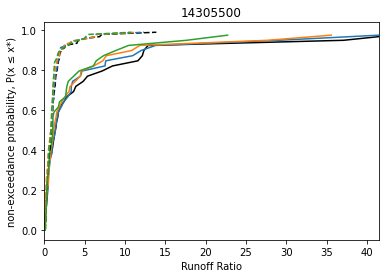

LSTM absolute mass error 0.25 0.21
MC-LSTM absolute mass error 0.21 0.21
SacSMA absolute mass error 0.36 0.38


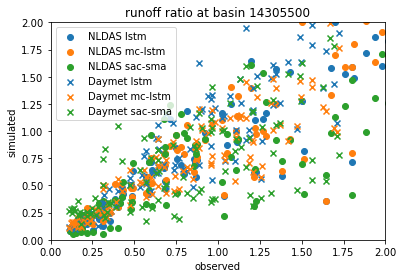

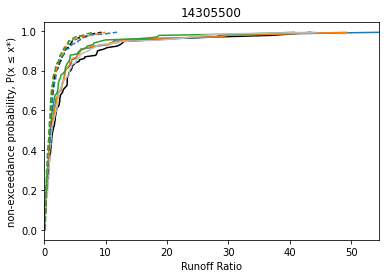

LSTM absolute mass error 0.25 0.27
MC-LSTM absolute mass error 0.32 0.31
SacSMA absolute mass error 0.5 0.45


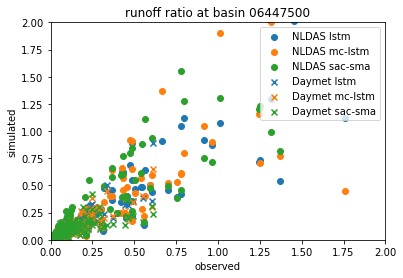

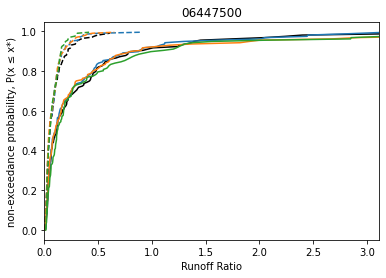

LSTM absolute mass error 0.36 0.29
MC-LSTM absolute mass error 0.46 0.39
SacSMA absolute mass error 0.53 0.51


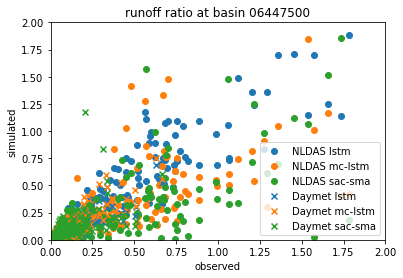

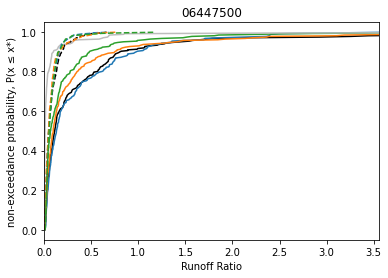

In [33]:
for i in [int(530 * np.random.rand()) for j in range(10)]:

    for tsplt in ['time_split1', 'time_split2']:
        
        spex = get_specifications(tsplt, 'nldas')
        
        basin_0str = spex["basin_list"][i]

        _nldas = events_results[tsplt]['nldas'][basin_0str]
        _daymet = events_results[tsplt]['daymet'][basin_0str]

        print("LSTM absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_lstm']),2), 
                                          np.round(np.mean(_daymet.loc[:,'AME_lstm']),2))
        print("MC-LSTM absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_mc']),2),
                                             np.round(np.mean(_daymet.loc[:,'AME_mc']),2))
        print("SacSMA absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_sac']),2),
                                            np.round(np.mean(_daymet.loc[:,'AME_sac']),2))

        scatter_plot_of_rr_events_for_basin(_nldas, _daymet, basin_0str, spex, plot_bounds=[0,2])
        plot_runoff_ratio_distribution(tsplt, basin_0str, _nldas, _daymet)

In [35]:
def plot_event_hydrograph(event, basin_0str,
                              flow_mm_nldas, flow_mm_daymet, 
                              forcing_nldas, forcing_daymet):
        
    print(event)
    sevd = event[0]# StartEventDate
    eevd = event[1]-1# EndEventDate

    flow_obs_nldas = np.array(flow_mm_nldas['obs'].iloc[sevd:eevd])
    flow_obs_daymet = np.array(flow_mm_daymet['obs'].iloc[sevd:eevd])
    flow_lstm_nldas = np.array(flow_mm_nldas['lstm'].iloc[sevd:eevd])
    flow_lstm_daymet = np.array(flow_mm_daymet['lstm'].iloc[sevd:eevd])
    flow_mc_nldas = np.array(flow_mm_nldas['mc'].iloc[sevd:eevd])
    flow_mc_daymet = np.array(flow_mm_daymet['mc'].iloc[sevd:eevd])
    flow_sac_nldas = np.array(flow_mm_nldas['sac'].iloc[sevd:eevd])
    flow_sac_daymet = np.array(flow_mm_daymet['sac'].iloc[sevd:eevd])    
    precip_nldas = forcing_nldas[precip_column_map['nldas']].values[sevd:eevd]
    precip_daymet = forcing_daymet[precip_column_map['daymet']].values[sevd:eevd]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(flow_obs_nldas, '*', label="Observed runoff", c="k")

    ax1.plot(flow_lstm_nldas, label="lstm nldas", c=colz[0])
    ax1.plot(flow_lstm_daymet, '--', label="lstm daymet", c=colz[0])
    ax1.plot(flow_mc_nldas, label="MC-LSTM nldas", c=colz[1])
    ax1.plot(flow_mc_daymet, '--', label="MC-LSTM daymet", c=colz[1])
    ax1.plot(flow_sac_nldas, label="SAC-SMA nldas", c=colz[2])
    ax1.plot(flow_sac_daymet, '--', label="SAC-SMA daymet", c=colz[2])
    ax2.plot(precip_nldas, label="precip nldas", c='k')
    ax2.plot(precip_daymet, '--', label="precip daymet", c='k')
    ax1.set_ylabel("Runoff [mm/day]")
    ax2.set_ylabel("Precip [mm/day]")
    ax1.legend(loc='center left', bbox_to_anchor=(-0.5, .3))
    ax2.legend(loc='center left', bbox_to_anchor=(1.1, .3))

    ts = pd.to_datetime(str(flow_mm_nldas['obs'].index[event[0]])) 
    d = ts.strftime('%Y.%m.%d')
    
    plt.title(f"{basin_0str}, {d}")
    
    plt.show()
    plt.close()

Number of precipitation events 128 above threshold 0.28mm and a window below 0.02mm
Number of precipitation events 302 above threshold 2.12mm and a window below 0.21mm
[75, 82]


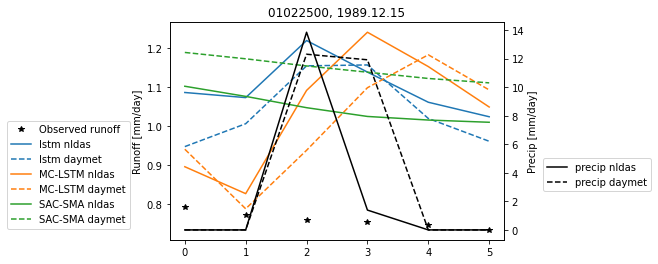

[125, 132]


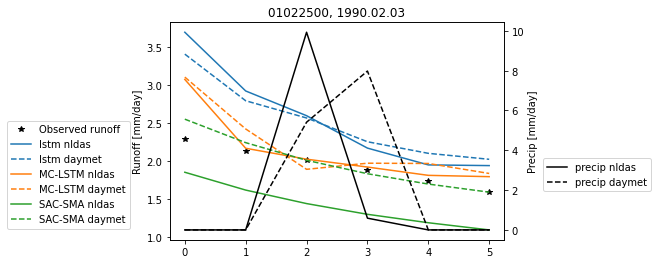

[303, 309]


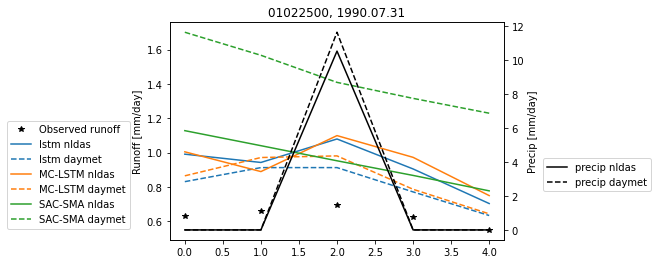

[397, 403]


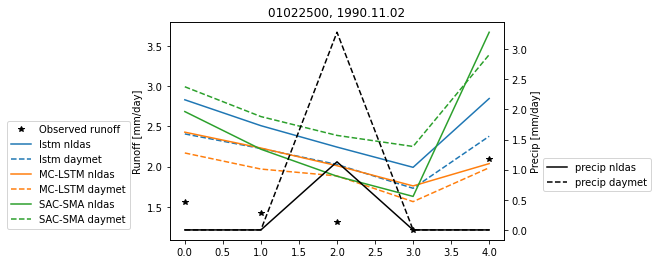

[950, 957]


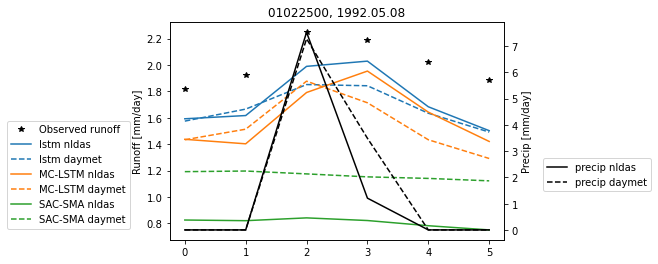

[1184, 1193]


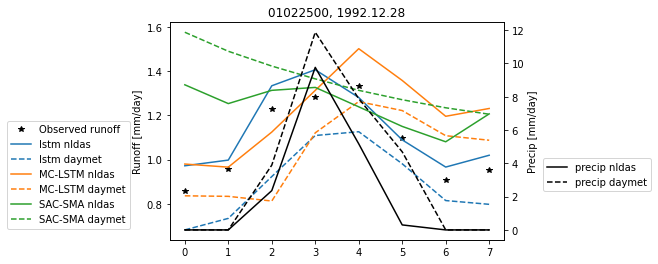

[1239, 1248]


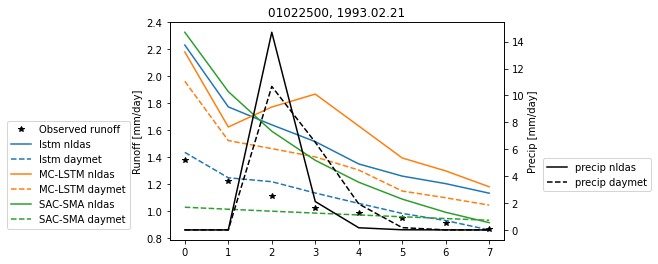

[1877, 1883]


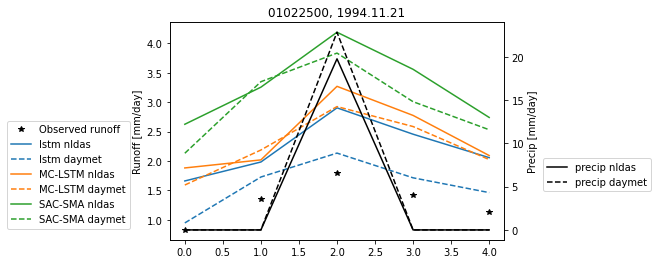

[1963, 1969]


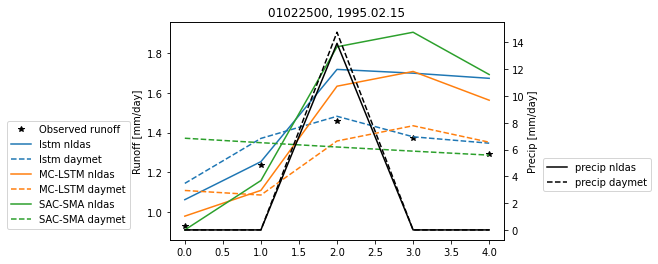

[2152, 2158]


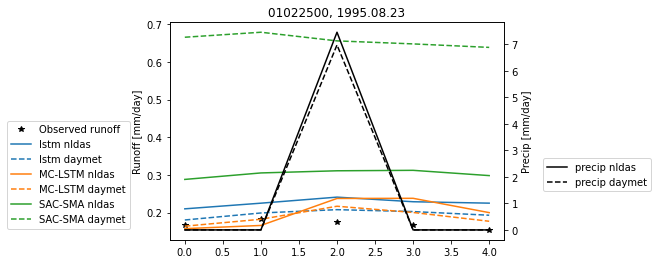

[2204, 2211]


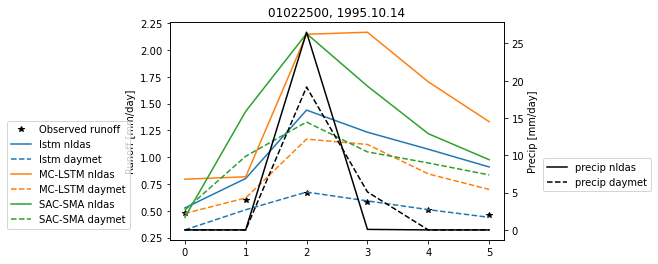

[2276, 2283]


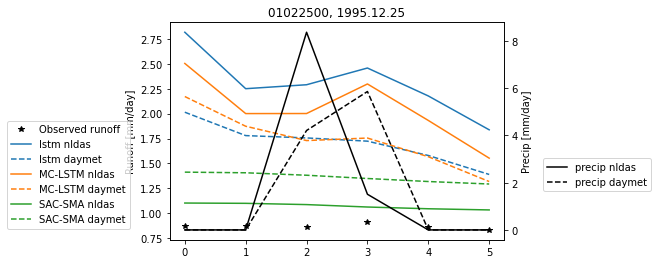

[2558, 2564]


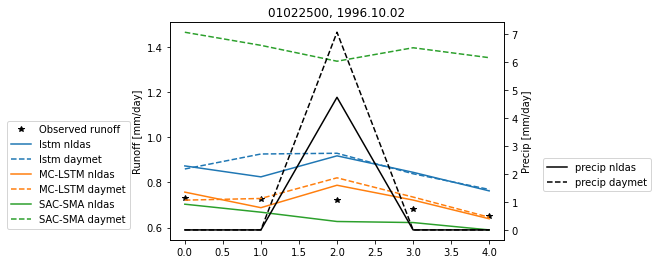

[2750, 2757]


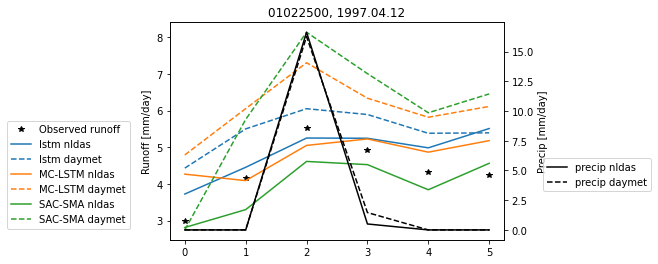

[3061, 3069]


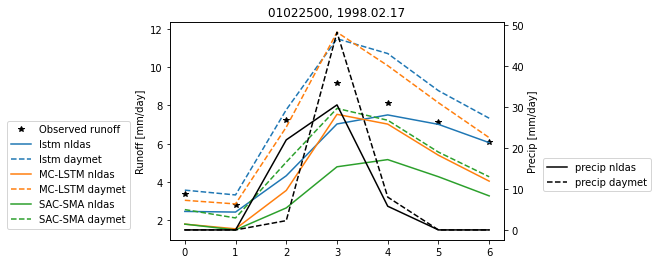

[3282, 3289]


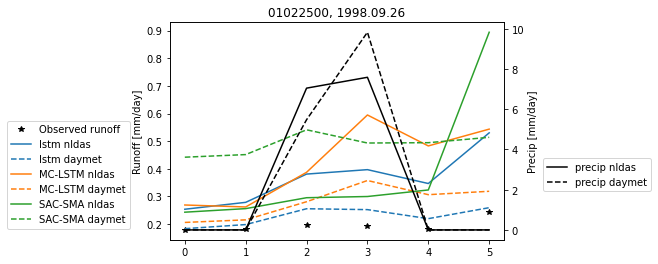

[3300, 3307]


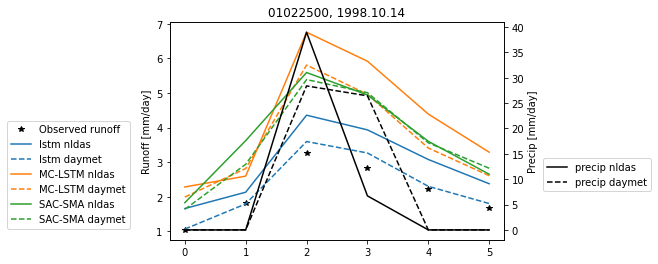

[3426, 3433]


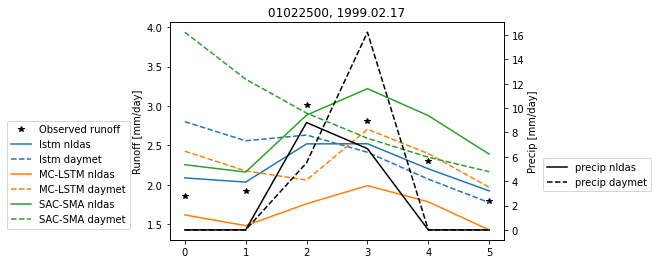

[3635, 3644]


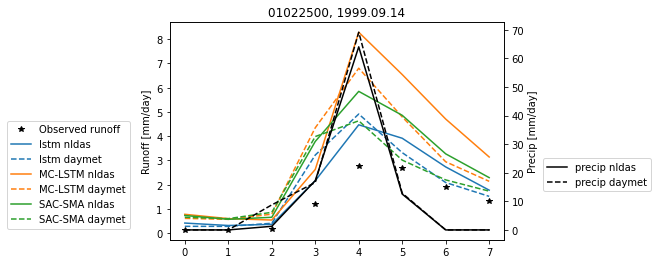

Number of precipitation events 92 above threshold 0.27mm and a window below 0.02mm
Number of precipitation events 284 above threshold 2.4mm and a window below 0.33mm
[404, 411]


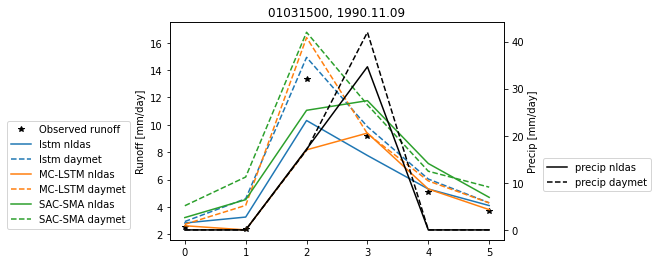

[411, 420]


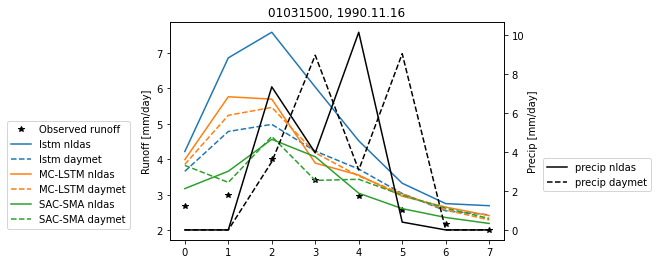

[709, 715]


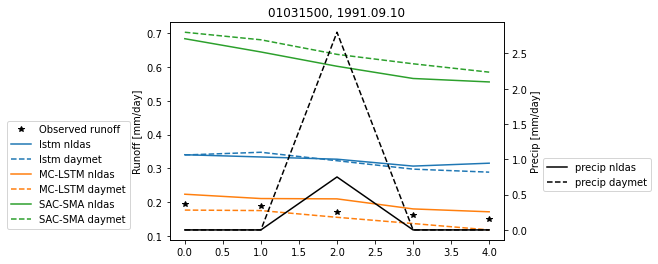

[978, 986]


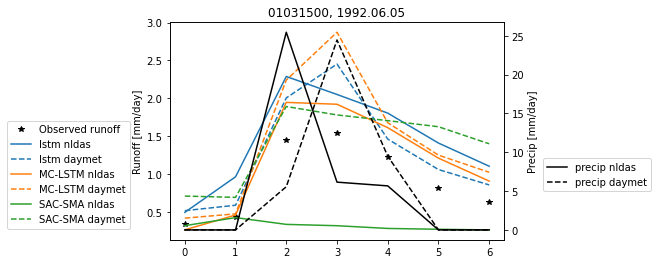

[1579, 1586]


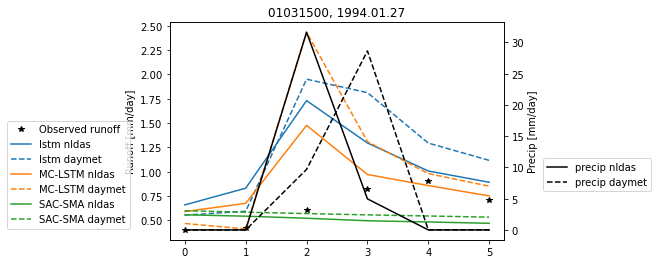

[1834, 1840]


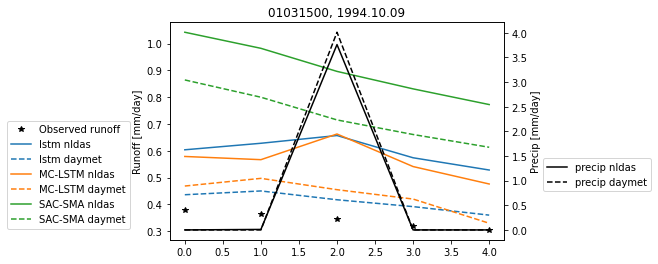

[1903, 1910]


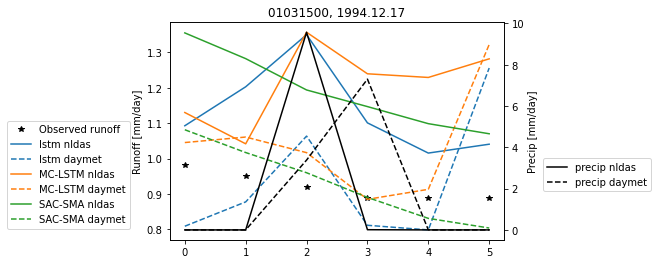

[2558, 2564]


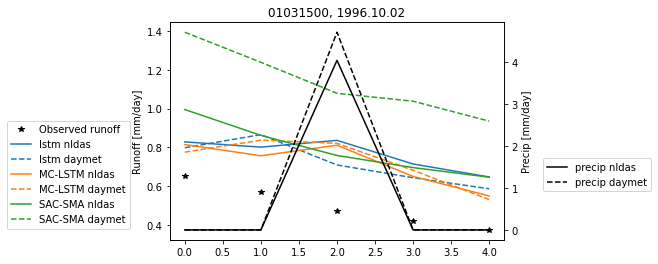

[2657, 2664]


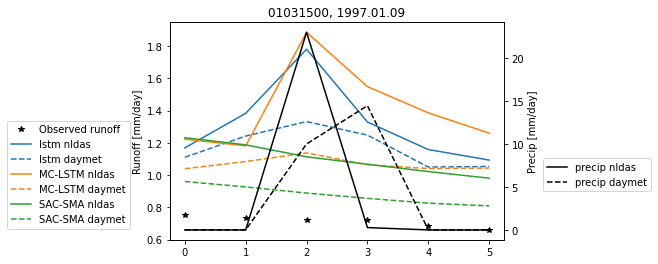

[3055, 3062]


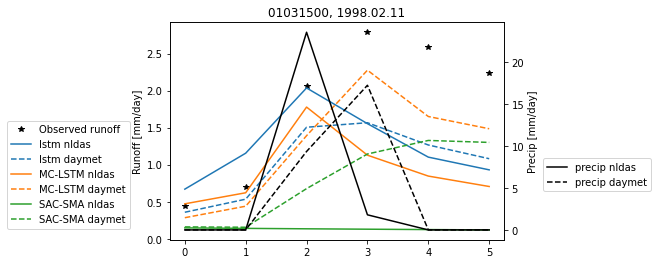

[3426, 3433]


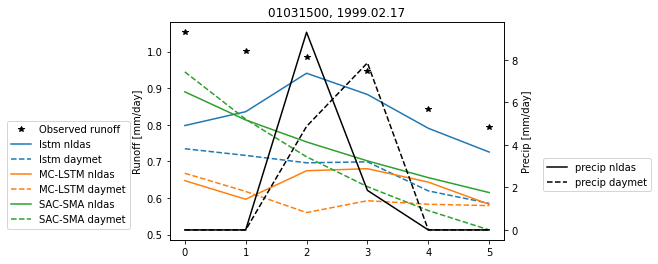

[3434, 3440]


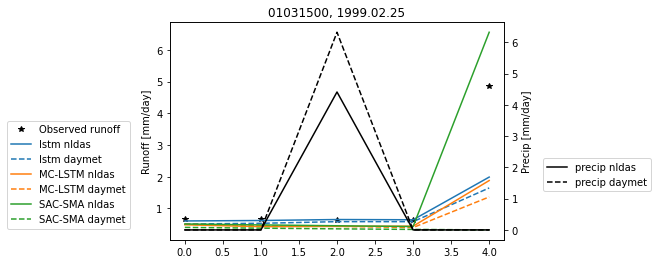

[3471, 3477]


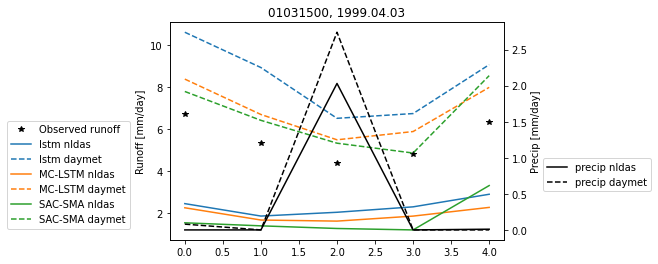

Number of precipitation events 78 above threshold 0.2mm and a window below 0.02mm
Number of precipitation events 295 above threshold 2.0mm and a window below 0.11mm
[933, 942]


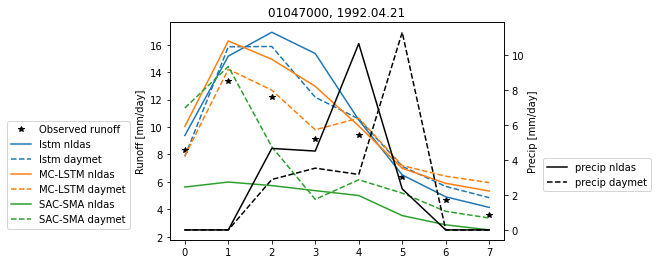

[2185, 2193]


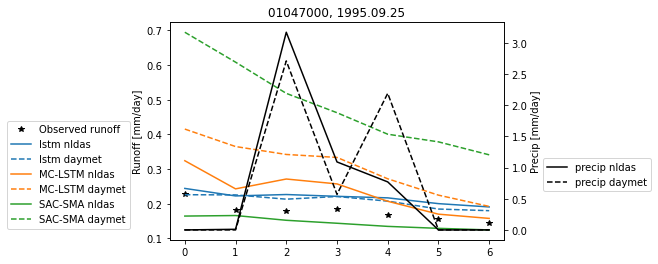

[2374, 2380]


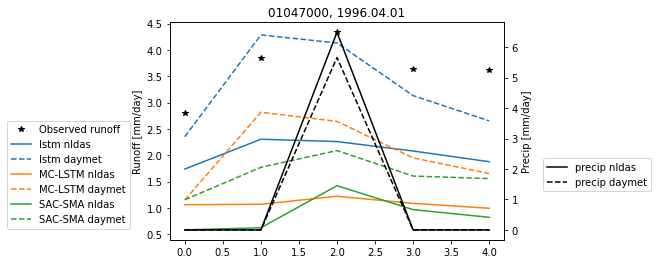

[2558, 2564]


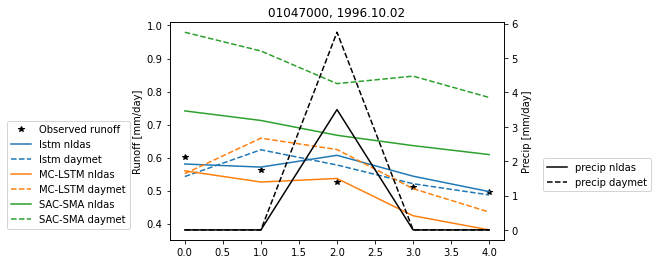

[2755, 2763]


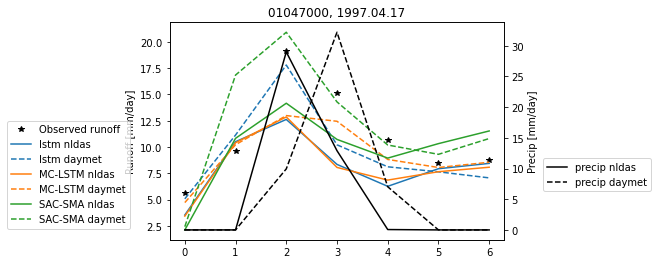

Number of precipitation events 55 above threshold 0.35mm and a window below 0.03mm
Number of precipitation events 217 above threshold 2.13mm and a window below 0.14mm
[922, 929]


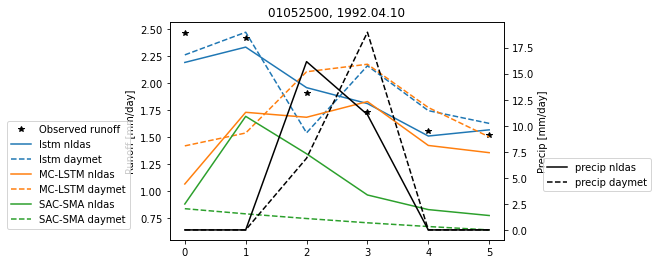

[933, 942]


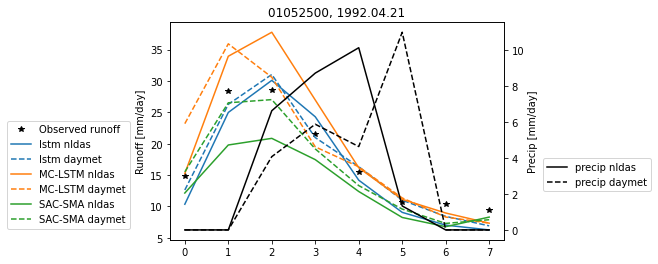

[2374, 2380]


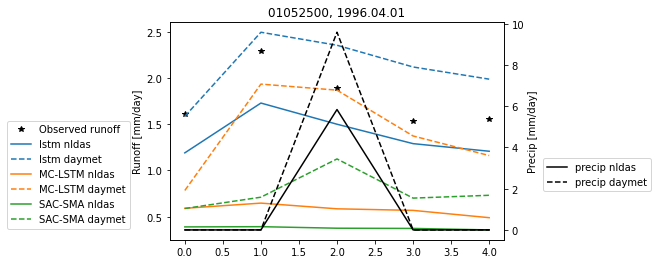

[2431, 2439]


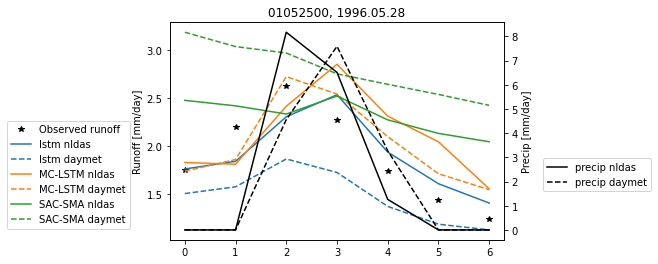

[3635, 3644]


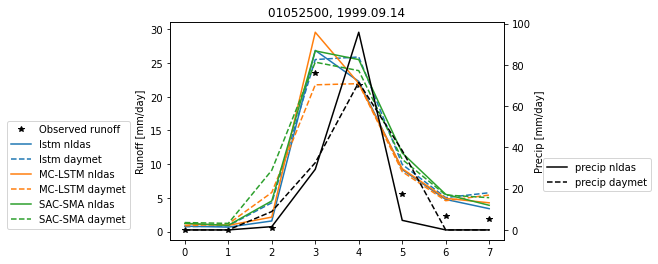

In [36]:
tsplt ='time_split1'

overlapping_events = {basin:[] for basin in spex["basin_list"]}
        
spex = get_specifications(tsplt, 'nldas')
start_date = spex['start_date']
end_date = spex['end_date']
    
    
for random_basin in range(4):#[int(530 * np.random.rand()) for j in range(3)]:
    
    basin_0str = spex["basin_list"][random_basin]
        
    spex = get_specifications(tsplt, 'nldas')
    forcing_nldas, precip_events_nldas = load_forcing_and_identify_events(tsplt, 
                                                              basin_0str, 
                                                              file_name_map, 
                                                              'nldas')

    spex = get_specifications(tsplt, 'daymet')
    forcing_daymet, precip_events_daymet = load_forcing_and_identify_events(tsplt, 
                                                              basin_0str, 
                                                              file_name_map, 
                                                              'daymet')
    
    for i in precip_events_nldas:
        if i in precip_events_daymet:
            overlapping_events[basin_0str].append(i)

            
    flow_mm_nldas, _ = get_precip_and_flows(tsplt, 
                                             'nldas', 
                                             basin_0str, 
                                             start_date, 
                                             end_date)
    flow_mm_daymet, _ = get_precip_and_flows(tsplt, 
                                             'daymet', 
                                             basin_0str, 
                                             start_date, 
                                             end_date)    

    for event in overlapping_events[basin_0str]:
        plot_event_hydrograph(event, basin_0str,
                              flow_mm_nldas, flow_mm_daymet, 
                              forcing_nldas, forcing_daymet)
    
